## Lorenz system

$$ \begin{cases}\frac{dx}{dt} = \sigma\,(y-x) \\ \frac{dy}{dt} = x\,(\rho-z) - y\\ \frac{dz}{dt} = x\,y - \beta\,z\end{cases} \text{ with the parameters: } \begin{cases} \sigma = 10\\ \beta = \frac{8}{3}\\ \rho = 6 \end{cases}$$

In [1]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
def load_data_inv():
    data = sio.loadmat("../dataset/Lorenz.mat")
    t_test, u_test = data["t_test"], data["u_test"]
    t_u_train, u_train = data["t_train"], data["u_train"]
    t_f_train, f_train = data["t_f_train"], data["f_train"]
    noise = 0.1
    return t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test

In [3]:
def ode_fn(t,u,sigma, beta):
    rho = 6
    x, y, z = tf.split(u, 3, axis=-1)
    x_t, y_t, z_t = tf.gradients(x,t)[0], tf.gradients(y,t)[0], tf.gradients(z,t)[0]
    
    f1 = x_t - sigma*(y-x)
    f2 = y_t - x*(rho-z) + y
    f3 = z_t - x*y + beta*z
    
    return tf.concat([f1,f2,f3], axis=-1)

In [4]:
@neuq.utils.timer
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers):
    t_u3_train = t_u_train
    u1_train, u2_train, u3_train = u_train[:, 0:1], u_train[:, 1:2], u_train[:, 2:3]
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=6, sigma=4),
    )
    process_r1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=10, sigma=1),
    )
    process_r2 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=3, sigma=1),
    )
    
    # build likelihood
    likelihood_u12 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u2_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 1]],
        sigma=noise,
    )
    likelihood_u3 = neuq.likelihoods.Normal(
        inputs=t_u3_train,
        targets=u3_train,
        processes=[process_u],
        out_dims=[[2]],
        sigma=noise,
    )
    
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_r1, process_r2],
        pde=ode_fn,
        sigma=noise,
    )
    
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_r1, process_r2],
        likelihoods=[likelihood_u12, likelihood_u3, likelihood_f],
    )
    
    # assign and compile method
    # Change parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(
        num_samples=2000,
        num_burnin=5000,
        init_time_step=0.1,
        leapfrog_step=50,
        seed=777,
    )
    model.compile(method)
    
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n"%(np.mean(results)))
    
    processes = [process_u, process_r1, process_r2]

    return processes, samples, model

@neuq.utils.timer
def Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers):
    t_u3_train = t_u_train
    u1_train, u2_train, u3_train = u_train[:, 0:1], u_train[:, 1:2], u_train[:, 2:3]
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        posterior=neuq_vars.fnn.Trainable(
            layers=layers, regularizer=tf.keras.regularizers.l2(1e-7)
        ),
    )
    process_r1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=10),
    )
    process_r2 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=3),
    )
    
    # build likelihood
    likelihood_u12 = neuq.likelihoods.MSE(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u2_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 1]],
    )
    likelihood_u3 = neuq.likelihoods.MSE(
        inputs=t_u3_train,
        targets=u3_train,
        processes=[process_u],
        out_dims=[[2]],
    )
    
    likelihood_f = neuq.likelihoods.MSE(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_r1, process_r2],
        pde=ode_fn,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_r1, process_r2],
        likelihoods=[likelihood_u12, likelihood_u3, likelihood_f],
    )
    # assign and compile method
    method = neuq.inferences.DEns(
        num_samples=20, num_iterations=20000, optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    # obtain posterior samples
    samples = model.run()
    samples = neuq.utils.batch_samples(samples)  # reshape

    processes = [process_u, process_r1, process_r2]
    return processes, samples, model

################## Load data and specify some hyperparameters ####################
t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test = load_data_inv()

layers = [1, 100, 100, 3]

In [5]:
def plots(u_pred, t_test, u_test, t_u_train, u_train):
    u1_pred, u2_pred, u3_pred = np.split(u_pred, 3, axis=-1)
    u1_test, u2_test, u3_test = np.split(u_test, 3, axis=-1)
    u1_train, u2_train = u_train[:,0:1], u_train[:,1:2]  # training data
    t_u3_train = t_u_train[:]
    u3_train = u_train[:, 2:3]

    neuq.utils.hist(r1_pred, name=r"value of $\sigma$")
    neuq.utils.hist(r2_pred, name=r"value of $\beta$")
    
    neuq.utils.plot1d(
        t_u_train,
        u1_train,
        t_test,
        u1_test,
        u1_pred[..., 0],
        title="inference over mode 1",
    )
    neuq.utils.plot1d(
        t_u_train,
        u2_train,
        t_test,
        u2_test,
        u2_pred[..., 0],
        title="inference over mode 2",
    )
    neuq.utils.plot1d(
        t_u3_train,
        u3_train,
        t_test,
        u3_test,
        u3_pred[..., 0],
        title="inference over mode 3",
    )

In [6]:
############################### Choose framework #################################
processes, samples, model = Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers)

#processes, samples, model = Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.423 

Execution time for 'Samplable' function is: 427.207 s, 7.120 mins


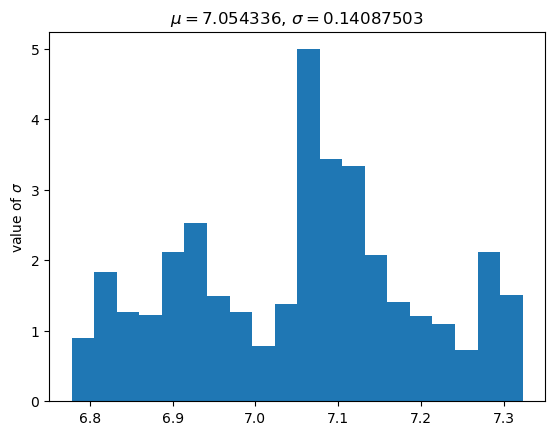

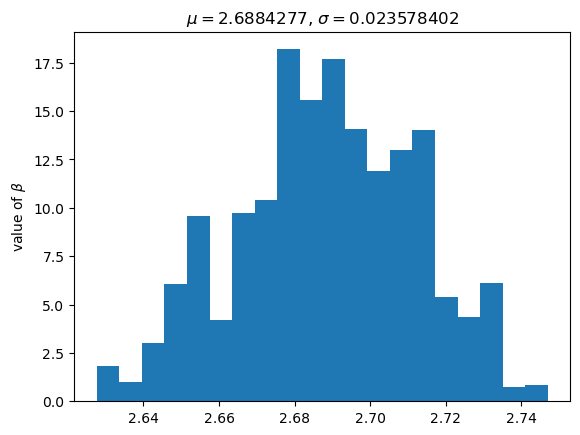

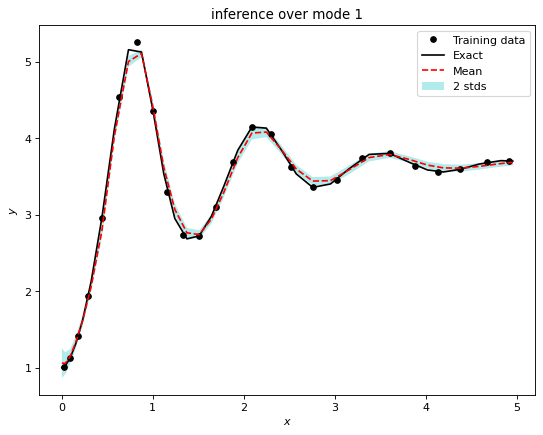

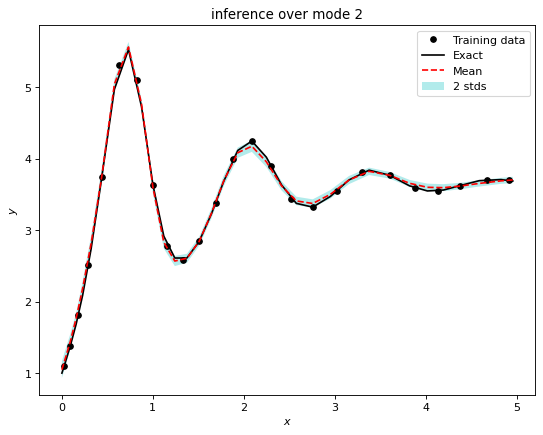

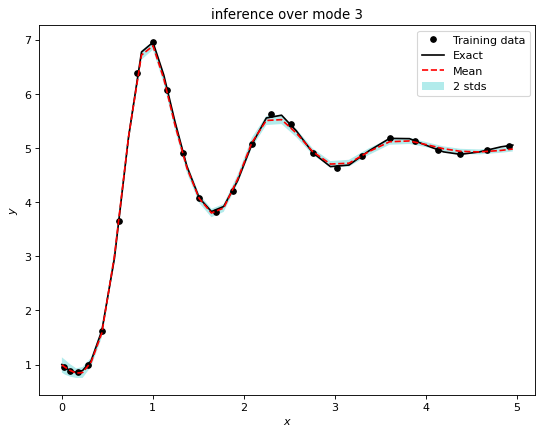

In [7]:
u_pred, r1_pred, r2_pred = model.predict(t_test, samples, processes, pde_fn=None)
plots(u_pred, t_test, u_test, t_u_train, u_train)

In [8]:
############################### Choose framework #################################
#processes, samples, model = Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers)

processes, samples, model = Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers)

Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

Generating 0th sample by deep ensemble...
Iteration:  0 , loss:  31.163725
Iteration:  100 , loss:  7.574893
Iteration:  200 , loss:  3.9319263
Iteration:  300 , loss:  3.1898742
Iteration:  400 , loss:  3.07895
Iteration:  500 , loss:  2.9717078
Iteration:  600 , loss:  2.8670187
Iteration:  700 , loss:  2.7651634
Iteration:  800 , loss:  2.6587968
Iteration:  900 , loss:  2.5249305
Iteration:  1000 , loss:  2.3050416
Iteration:  1100 , loss:  1.9846363
Iteration:  1200 , loss:  1.5493988
Iteration:  1300 , loss:  1.0767045
Iteration:  1400 , loss:  0.756619
Iteration:  1500 , loss:  0.6089649
Iteration:  1600 , loss:  0.5401866
Iteration:  1700 , loss:  0.48051983
Iteration:  1800 , loss:  0.44076064
Iteration:  1900 , loss:  0.4076078
Iteration:  2000 , loss:  0.37562248
Iteration:  2100 , loss:  0.34498802
Iteration:  2200 , loss:  0.33556736
Iteration:  2300 , loss:  0.29821283
Iteration:  2400 , loss:  0.277567

Iteration:  1400 , loss:  0.6548421
Iteration:  1500 , loss:  0.53332394
Iteration:  1600 , loss:  0.47216922
Iteration:  1700 , loss:  0.42923245
Iteration:  1800 , loss:  0.39177704
Iteration:  1900 , loss:  0.3586604
Iteration:  2000 , loss:  0.3281313
Iteration:  2100 , loss:  0.30083963
Iteration:  2200 , loss:  0.27726123
Iteration:  2300 , loss:  0.25733945
Iteration:  2400 , loss:  0.24074984
Iteration:  2500 , loss:  0.22731905
Iteration:  2600 , loss:  0.21524495
Iteration:  2700 , loss:  0.20456372
Iteration:  2800 , loss:  0.19820605
Iteration:  2900 , loss:  0.1850524
Iteration:  3000 , loss:  0.17500588
Iteration:  3100 , loss:  0.16433117
Iteration:  3200 , loss:  0.15024854
Iteration:  3300 , loss:  0.13564306
Iteration:  3400 , loss:  0.120179735
Iteration:  3500 , loss:  0.10554173
Iteration:  3600 , loss:  0.09228468
Iteration:  3700 , loss:  0.08134614
Iteration:  3800 , loss:  0.072235964
Iteration:  3900 , loss:  0.11864425
Iteration:  4000 , loss:  0.05824068
Ite

Iteration:  2900 , loss:  0.1649962
Iteration:  3000 , loss:  0.15233673
Iteration:  3100 , loss:  0.13902399
Iteration:  3200 , loss:  0.12485542
Iteration:  3300 , loss:  0.11005046
Iteration:  3400 , loss:  0.09633579
Iteration:  3500 , loss:  0.08470138
Iteration:  3600 , loss:  0.0753211
Iteration:  3700 , loss:  0.068481155
Iteration:  3800 , loss:  0.06268395
Iteration:  3900 , loss:  0.058385465
Iteration:  4000 , loss:  0.1224043
Iteration:  4100 , loss:  0.052390914
Iteration:  4200 , loss:  0.050271675
Iteration:  4300 , loss:  0.048559617
Iteration:  4400 , loss:  0.047092773
Iteration:  4500 , loss:  0.045763627
Iteration:  4600 , loss:  0.044699203
Iteration:  4700 , loss:  0.043407403
Iteration:  4800 , loss:  0.042231515
Iteration:  4900 , loss:  0.041175712
Iteration:  5000 , loss:  0.039891787
Iteration:  5100 , loss:  0.038654618
Iteration:  5200 , loss:  0.03751864
Iteration:  5300 , loss:  0.036167644
Iteration:  5400 , loss:  0.03483815
Iteration:  5500 , loss:  0

Iteration:  4200 , loss:  0.032043498
Iteration:  4300 , loss:  0.034177363
Iteration:  4400 , loss:  0.030182846
Iteration:  4500 , loss:  0.029342255
Iteration:  4600 , loss:  0.03215877
Iteration:  4700 , loss:  0.027872441
Iteration:  4800 , loss:  0.02720953
Iteration:  4900 , loss:  0.026833909
Iteration:  5000 , loss:  0.026085403
Iteration:  5100 , loss:  0.025593655
Iteration:  5200 , loss:  0.025158277
Iteration:  5300 , loss:  0.02473536
Iteration:  5400 , loss:  0.024351858
Iteration:  5500 , loss:  0.02405744
Iteration:  5600 , loss:  0.0237309
Iteration:  5700 , loss:  0.023435697
Iteration:  5800 , loss:  0.023329113
Iteration:  5900 , loss:  0.022946449
Iteration:  6000 , loss:  0.022850785
Iteration:  6100 , loss:  0.02255061
Iteration:  6200 , loss:  0.022350466
Iteration:  6300 , loss:  0.02217073
Iteration:  6400 , loss:  0.022045832
Iteration:  6500 , loss:  0.021872591
Iteration:  6600 , loss:  0.03486468
Iteration:  6700 , loss:  0.02161861
Iteration:  6800 , los

Iteration:  5600 , loss:  0.110543795
Iteration:  5700 , loss:  0.034735464
Iteration:  5800 , loss:  0.033612497
Iteration:  5900 , loss:  0.037651695
Iteration:  6000 , loss:  0.0315538
Iteration:  6100 , loss:  0.030590821
Iteration:  6200 , loss:  0.048067708
Iteration:  6300 , loss:  0.028809233
Iteration:  6400 , loss:  0.027973864
Iteration:  6500 , loss:  0.02721788
Iteration:  6600 , loss:  0.026442284
Iteration:  6700 , loss:  0.025698366
Iteration:  6800 , loss:  0.025054237
Iteration:  6900 , loss:  0.024192603
Iteration:  7000 , loss:  0.023496192
Iteration:  7100 , loss:  0.022993883
Iteration:  7200 , loss:  0.022528399
Iteration:  7300 , loss:  0.022106465
Iteration:  7400 , loss:  0.021734627
Iteration:  7500 , loss:  0.021333722
Iteration:  7600 , loss:  0.026734075
Iteration:  7700 , loss:  0.020498965
Iteration:  7800 , loss:  0.020306893
Iteration:  7900 , loss:  0.019506792
Iteration:  8000 , loss:  0.018895922
Iteration:  8100 , loss:  0.023668595
Iteration:  820

Iteration:  7000 , loss:  0.0233561
Iteration:  7100 , loss:  0.02113923
Iteration:  7200 , loss:  0.020750487
Iteration:  7300 , loss:  0.024613077
Iteration:  7400 , loss:  0.020101612
Iteration:  7500 , loss:  0.019772958
Iteration:  7600 , loss:  0.0195005
Iteration:  7700 , loss:  0.019147059
Iteration:  7800 , loss:  0.02364511
Iteration:  7900 , loss:  0.018489236
Iteration:  8000 , loss:  0.018103298
Iteration:  8100 , loss:  0.018011605
Iteration:  8200 , loss:  0.01737144
Iteration:  8300 , loss:  0.019209722
Iteration:  8400 , loss:  0.016596798
Iteration:  8500 , loss:  0.016152745
Iteration:  8600 , loss:  0.01583071
Iteration:  8700 , loss:  0.015324899
Iteration:  8800 , loss:  0.017002014
Iteration:  8900 , loss:  0.014445876
Iteration:  9000 , loss:  0.013970727
Iteration:  9100 , loss:  0.013569073
Iteration:  9200 , loss:  0.013411357
Iteration:  9300 , loss:  0.013991634
Iteration:  9400 , loss:  0.012406981
Iteration:  9500 , loss:  0.012167572
Iteration:  9600 , l

Iteration:  8400 , loss:  0.035179526
Iteration:  8500 , loss:  0.15584297
Iteration:  8600 , loss:  0.032953966
Iteration:  8700 , loss:  0.031890526
Iteration:  8800 , loss:  0.03967454
Iteration:  8900 , loss:  0.029930321
Iteration:  9000 , loss:  0.02934426
Iteration:  9100 , loss:  0.028322568
Iteration:  9200 , loss:  0.035267733
Iteration:  9300 , loss:  0.026960736
Iteration:  9400 , loss:  0.026357777
Iteration:  9500 , loss:  0.025839686
Iteration:  9600 , loss:  0.025336193
Iteration:  9700 , loss:  0.025119554
Iteration:  9800 , loss:  0.024485545
Iteration:  9900 , loss:  0.026005248
Iteration:  10000 , loss:  0.023810279
Iteration:  10100 , loss:  0.023549596
Iteration:  10200 , loss:  0.023479711
Iteration:  10300 , loss:  0.023032486
Iteration:  10400 , loss:  0.02493372
Iteration:  10500 , loss:  0.02261917
Iteration:  10600 , loss:  0.027058952
Iteration:  10700 , loss:  0.022268796
Iteration:  10800 , loss:  0.022087414
Iteration:  10900 , loss:  0.021948058
Iterati

Iteration:  9900 , loss:  0.009055199
Iteration:  10000 , loss:  0.008779159
Iteration:  10100 , loss:  0.008474364
Iteration:  10200 , loss:  0.008254385
Iteration:  10300 , loss:  0.007930367
Iteration:  10400 , loss:  0.009196865
Iteration:  10500 , loss:  0.00741838
Iteration:  10600 , loss:  0.007158953
Iteration:  10700 , loss:  0.0069368267
Iteration:  10800 , loss:  0.019322835
Iteration:  10900 , loss:  0.0064806174
Iteration:  11000 , loss:  0.006627286
Iteration:  11100 , loss:  0.0060953335
Iteration:  11200 , loss:  0.005927917
Iteration:  11300 , loss:  0.020540344
Iteration:  11400 , loss:  0.005622895
Iteration:  11500 , loss:  0.0055246023
Iteration:  11600 , loss:  0.0064111017
Iteration:  11700 , loss:  0.0052620894
Iteration:  11800 , loss:  0.0052103465
Iteration:  11900 , loss:  0.0050703026
Iteration:  12000 , loss:  0.0049869977
Iteration:  12100 , loss:  0.0048921173
Iteration:  12200 , loss:  0.02437157
Iteration:  12300 , loss:  0.004719633
Iteration:  12400 

Iteration:  11200 , loss:  0.02229722
Iteration:  11300 , loss:  0.022088815
Iteration:  11400 , loss:  0.022073705
Iteration:  11500 , loss:  0.021761727
Iteration:  11600 , loss:  0.021673502
Iteration:  11700 , loss:  0.021437079
Iteration:  11800 , loss:  0.021241743
Iteration:  11900 , loss:  0.022129381
Iteration:  12000 , loss:  0.020903159
Iteration:  12100 , loss:  0.022392636
Iteration:  12200 , loss:  0.02055442
Iteration:  12300 , loss:  0.021288665
Iteration:  12400 , loss:  0.020376856
Iteration:  12500 , loss:  0.020555427
Iteration:  12600 , loss:  0.019738214
Iteration:  12700 , loss:  0.019578736
Iteration:  12800 , loss:  0.01933654
Iteration:  12900 , loss:  0.019874092
Iteration:  13000 , loss:  0.018911004
Iteration:  13100 , loss:  0.018691814
Iteration:  13200 , loss:  0.018479634
Iteration:  13300 , loss:  0.018676547
Iteration:  13400 , loss:  0.017987093
Iteration:  13500 , loss:  0.018673673
Iteration:  13600 , loss:  0.033694904
Iteration:  13700 , loss:  0

Iteration:  12600 , loss:  0.008354205
Iteration:  12700 , loss:  0.008354597
Iteration:  12800 , loss:  0.008124359
Iteration:  12900 , loss:  0.007868679
Iteration:  13000 , loss:  0.0077902754
Iteration:  13100 , loss:  0.007528938
Iteration:  13200 , loss:  0.007226619
Iteration:  13300 , loss:  0.0070981625
Iteration:  13400 , loss:  0.0067586107
Iteration:  13500 , loss:  0.046714127
Iteration:  13600 , loss:  0.006276818
Iteration:  13700 , loss:  0.0073348926
Iteration:  13800 , loss:  0.0057976297
Iteration:  13900 , loss:  0.006061672
Iteration:  14000 , loss:  0.016828425
Iteration:  14100 , loss:  0.005110659
Iteration:  14200 , loss:  0.0052629956
Iteration:  14300 , loss:  0.0047356123
Iteration:  14400 , loss:  0.006643657
Iteration:  14500 , loss:  0.00442987
Iteration:  14600 , loss:  0.004294201
Iteration:  14700 , loss:  0.0041767173
Iteration:  14800 , loss:  0.0040621986
Iteration:  14900 , loss:  0.003987714
Iteration:  15000 , loss:  0.005762947
Iteration:  15100

Iteration:  13900 , loss:  0.006109829
Iteration:  14000 , loss:  0.01864591
Iteration:  14100 , loss:  0.0060238265
Iteration:  14200 , loss:  0.0059690303
Iteration:  14300 , loss:  0.020812573
Iteration:  14400 , loss:  0.0058856285
Iteration:  14500 , loss:  0.010838882
Iteration:  14600 , loss:  0.005808386
Iteration:  14700 , loss:  0.0059988587
Iteration:  14800 , loss:  0.0057377135
Iteration:  14900 , loss:  0.007564296
Iteration:  15000 , loss:  0.0058308593
Iteration:  15100 , loss:  0.035409626
Iteration:  15200 , loss:  0.0056024794
Iteration:  15300 , loss:  0.014432853
Iteration:  15400 , loss:  0.0055393316
Iteration:  15500 , loss:  0.0064554703
Iteration:  15600 , loss:  0.005482463
Iteration:  15700 , loss:  0.0285831
Iteration:  15800 , loss:  0.005432155
Iteration:  15900 , loss:  0.005397744
Iteration:  16000 , loss:  0.0055334144
Iteration:  16100 , loss:  0.0053450805
Iteration:  16200 , loss:  0.0055908253
Iteration:  16300 , loss:  0.0052950787
Iteration:  164

Iteration:  15300 , loss:  0.008594913
Iteration:  15400 , loss:  0.0069111497
Iteration:  15500 , loss:  0.009091984
Iteration:  15600 , loss:  0.0068156105
Iteration:  15700 , loss:  0.0068025445
Iteration:  15800 , loss:  0.0067465347
Iteration:  15900 , loss:  0.006895863
Iteration:  16000 , loss:  0.0066781794
Iteration:  16100 , loss:  0.018479688
Iteration:  16200 , loss:  0.0066203643
Iteration:  16300 , loss:  0.01141136
Iteration:  16400 , loss:  0.0065461965
Iteration:  16500 , loss:  0.0065186494
Iteration:  16600 , loss:  0.0065917745
Iteration:  16700 , loss:  0.0064631035
Iteration:  16800 , loss:  0.008310986
Iteration:  16900 , loss:  0.0063926117
Iteration:  17000 , loss:  0.0066909473
Iteration:  17100 , loss:  0.006332393
Iteration:  17200 , loss:  0.007647508
Iteration:  17300 , loss:  0.0062700026
Iteration:  17400 , loss:  0.0062909597
Iteration:  17500 , loss:  0.0062617
Iteration:  17600 , loss:  0.027459927
Iteration:  17700 , loss:  0.0061534354
Iteration:  1

Iteration:  16500 , loss:  0.0012616592
Iteration:  16600 , loss:  0.009214367
Iteration:  16700 , loss:  0.0012187222
Iteration:  16800 , loss:  0.0025387385
Iteration:  16900 , loss:  0.0011808478
Iteration:  17000 , loss:  0.0020598674
Iteration:  17100 , loss:  0.0011479869
Iteration:  17200 , loss:  0.0014740331
Iteration:  17300 , loss:  0.0016691025
Iteration:  17400 , loss:  0.0010928493
Iteration:  17500 , loss:  0.0011012091
Iteration:  17600 , loss:  0.0062244954
Iteration:  17700 , loss:  0.0010385051
Iteration:  17800 , loss:  0.0027728456
Iteration:  17900 , loss:  0.0010012226
Iteration:  18000 , loss:  0.005560736
Iteration:  18100 , loss:  0.00096334796
Iteration:  18200 , loss:  0.00094309245
Iteration:  18300 , loss:  0.0009267536
Iteration:  18400 , loss:  0.0008991642
Iteration:  18500 , loss:  0.0009122778
Iteration:  18600 , loss:  0.000855564
Iteration:  18700 , loss:  0.0008469907
Iteration:  18800 , loss:  0.0012709573
Iteration:  18900 , loss:  0.0007824113
I

Iteration:  17800 , loss:  0.006062198
Iteration:  17900 , loss:  0.0048559206
Iteration:  18000 , loss:  0.004823511
Iteration:  18100 , loss:  0.0093951775
Iteration:  18200 , loss:  0.0047384435
Iteration:  18300 , loss:  0.004781596
Iteration:  18400 , loss:  0.0047444627
Iteration:  18500 , loss:  0.007951314
Iteration:  18600 , loss:  0.004586736
Iteration:  18700 , loss:  0.00691393
Iteration:  18800 , loss:  0.0045051086
Iteration:  18900 , loss:  0.0046038735
Iteration:  19000 , loss:  0.0045254217
Iteration:  19100 , loss:  0.0045653773
Iteration:  19200 , loss:  0.02357392
Iteration:  19300 , loss:  0.0042990195
Iteration:  19400 , loss:  0.0042652762
Iteration:  19500 , loss:  0.009129788
Iteration:  19600 , loss:  0.004316577
Iteration:  19700 , loss:  0.012752749
Iteration:  19800 , loss:  0.004767762
Iteration:  19900 , loss:  0.005389816
Generating 14th sample by deep ensemble...
Iteration:  0 , loss:  42.674095
Iteration:  100 , loss:  8.602576
Iteration:  200 , loss: 

Iteration:  19200 , loss:  0.0032647746
Iteration:  19300 , loss:  0.0023796628
Iteration:  19400 , loss:  0.002637274
Iteration:  19500 , loss:  0.0024541405
Iteration:  19600 , loss:  0.009577829
Iteration:  19700 , loss:  0.0022406187
Iteration:  19800 , loss:  0.008306054
Iteration:  19900 , loss:  0.0021759144
Generating 15th sample by deep ensemble...
Iteration:  0 , loss:  36.69977
Iteration:  100 , loss:  8.056943
Iteration:  200 , loss:  4.3700104
Iteration:  300 , loss:  3.264021
Iteration:  400 , loss:  3.146225
Iteration:  500 , loss:  3.0391047
Iteration:  600 , loss:  2.9337983
Iteration:  700 , loss:  2.8349736
Iteration:  800 , loss:  2.7431214
Iteration:  900 , loss:  2.654907
Iteration:  1000 , loss:  2.5612159
Iteration:  1100 , loss:  2.4421384
Iteration:  1200 , loss:  2.277321
Iteration:  1300 , loss:  2.057546
Iteration:  1400 , loss:  1.7499806
Iteration:  1500 , loss:  1.3890204
Iteration:  1600 , loss:  1.1235226
Iteration:  1700 , loss:  0.95567006
Iteration:

Iteration:  500 , loss:  2.7834315
Iteration:  600 , loss:  2.6636412
Iteration:  700 , loss:  2.561288
Iteration:  800 , loss:  2.4610734
Iteration:  900 , loss:  2.3313165
Iteration:  1000 , loss:  2.1036572
Iteration:  1100 , loss:  1.6838909
Iteration:  1200 , loss:  1.2029339
Iteration:  1300 , loss:  0.75796604
Iteration:  1400 , loss:  0.5947117
Iteration:  1500 , loss:  0.49668735
Iteration:  1600 , loss:  0.42735514
Iteration:  1700 , loss:  0.3698547
Iteration:  1800 , loss:  0.31870726
Iteration:  1900 , loss:  0.27628967
Iteration:  2000 , loss:  0.24325374
Iteration:  2100 , loss:  0.2179579
Iteration:  2200 , loss:  0.20921572
Iteration:  2300 , loss:  0.17785738
Iteration:  2400 , loss:  0.1590189
Iteration:  2500 , loss:  0.14637755
Iteration:  2600 , loss:  0.12467995
Iteration:  2700 , loss:  0.10961055
Iteration:  2800 , loss:  0.09690331
Iteration:  2900 , loss:  0.08705647
Iteration:  3000 , loss:  0.079559304
Iteration:  3100 , loss:  0.07390356
Iteration:  3200 ,

Iteration:  1800 , loss:  0.39407516
Iteration:  1900 , loss:  0.32373685
Iteration:  2000 , loss:  0.28050584
Iteration:  2100 , loss:  0.24614948
Iteration:  2200 , loss:  0.2206386
Iteration:  2300 , loss:  0.20155099
Iteration:  2400 , loss:  0.18522212
Iteration:  2500 , loss:  0.17067046
Iteration:  2600 , loss:  0.15749869
Iteration:  2700 , loss:  0.14547212
Iteration:  2800 , loss:  0.13387166
Iteration:  2900 , loss:  0.13322498
Iteration:  3000 , loss:  0.107953355
Iteration:  3100 , loss:  0.0941442
Iteration:  3200 , loss:  0.08193111
Iteration:  3300 , loss:  0.072817
Iteration:  3400 , loss:  0.06619705
Iteration:  3500 , loss:  0.061275963
Iteration:  3600 , loss:  0.05768964
Iteration:  3700 , loss:  0.05474409
Iteration:  3800 , loss:  0.052486185
Iteration:  3900 , loss:  0.0507609
Iteration:  4000 , loss:  0.049319956
Iteration:  4100 , loss:  0.048120487
Iteration:  4200 , loss:  0.047140203
Iteration:  4300 , loss:  0.04615096
Iteration:  4400 , loss:  0.10089943


Iteration:  3200 , loss:  0.09639213
Iteration:  3300 , loss:  0.0810449
Iteration:  3400 , loss:  0.07325509
Iteration:  3500 , loss:  0.066504195
Iteration:  3600 , loss:  0.061514344
Iteration:  3700 , loss:  0.059833802
Iteration:  3800 , loss:  0.054865338
Iteration:  3900 , loss:  0.05260481
Iteration:  4000 , loss:  0.053319324
Iteration:  4100 , loss:  0.049372833
Iteration:  4200 , loss:  0.04811986
Iteration:  4300 , loss:  0.047084235
Iteration:  4400 , loss:  0.04608677
Iteration:  4500 , loss:  0.04504721
Iteration:  4600 , loss:  0.044084307
Iteration:  4700 , loss:  0.043112963
Iteration:  4800 , loss:  0.04219992
Iteration:  4900 , loss:  0.041178588
Iteration:  5000 , loss:  0.07588083
Iteration:  5100 , loss:  0.039176673
Iteration:  5200 , loss:  0.038157906
Iteration:  5300 , loss:  0.05759747
Iteration:  5400 , loss:  0.036079995
Iteration:  5500 , loss:  0.03503247
Iteration:  5600 , loss:  0.03444622
Iteration:  5700 , loss:  0.032980118
Iteration:  5800 , loss: 

Iteration:  4600 , loss:  0.039862916
Iteration:  4700 , loss:  0.03892374
Iteration:  4800 , loss:  0.09610189
Iteration:  4900 , loss:  0.037064932
Iteration:  5000 , loss:  0.03613759
Iteration:  5100 , loss:  0.03525568
Iteration:  5200 , loss:  0.034365807
Iteration:  5300 , loss:  0.03601215
Iteration:  5400 , loss:  0.032713868
Iteration:  5500 , loss:  0.031942897
Iteration:  5600 , loss:  0.031854603
Iteration:  5700 , loss:  0.030472435
Iteration:  5800 , loss:  0.02975716
Iteration:  5900 , loss:  0.029329874
Iteration:  6000 , loss:  0.028393956
Iteration:  6100 , loss:  0.02771182
Iteration:  6200 , loss:  0.029685073
Iteration:  6300 , loss:  0.026332654
Iteration:  6400 , loss:  0.025601607
Iteration:  6500 , loss:  0.024900807
Iteration:  6600 , loss:  0.024129225
Iteration:  6700 , loss:  0.024581915
Iteration:  6800 , loss:  0.022477522
Iteration:  6900 , loss:  0.022969726
Iteration:  7000 , loss:  0.020612055
Iteration:  7100 , loss:  0.0195792
Iteration:  7200 , lo

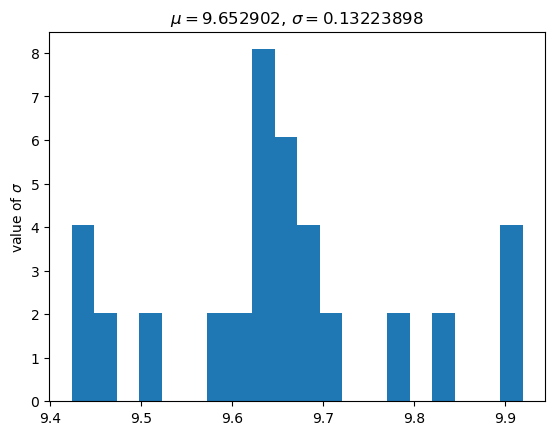

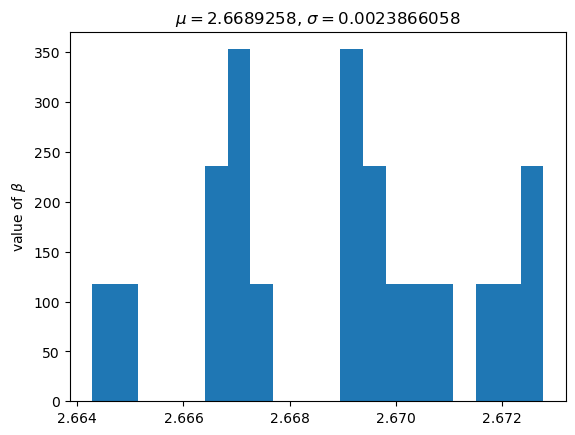

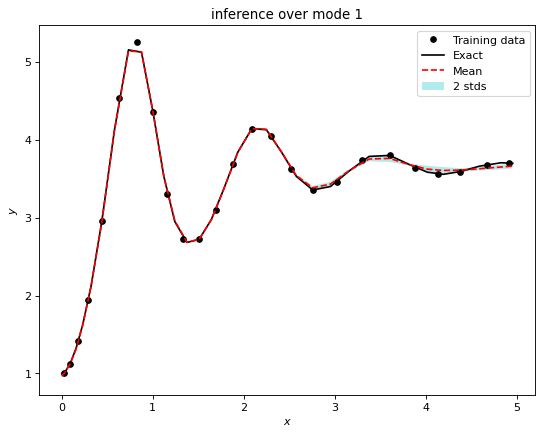

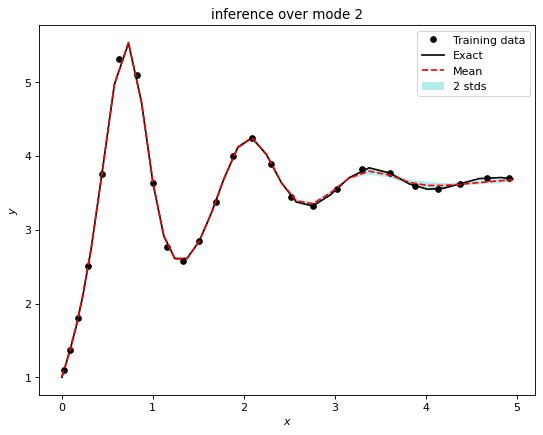

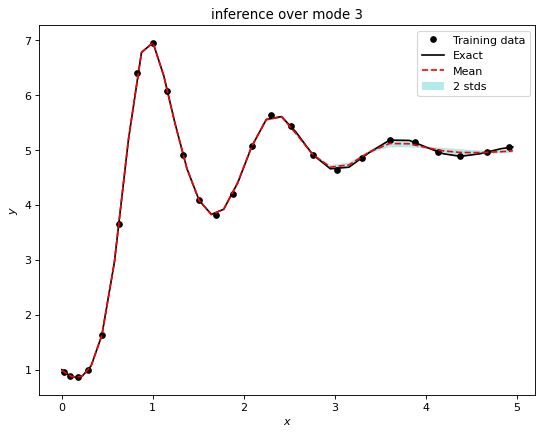

In [9]:
u_pred, r1_pred, r2_pred = model.predict(t_test, samples, processes, pde_fn=None)
plots(u_pred, t_test, u_test, t_u_train, u_train)